<b>Problem:</b>
<p>Breast cancer is the most deadly type of cancer and the highest incidence in women worldwide. One way to address this problem is early detection of possible anomalies. The Ministry of Health of Peru is promoting early detection of breast cancer through  mammography studies. However, mammograms do not have a very good quality and it is required processing and analyzing the images to aid diagnosis.</p>
<p>For this problem, you have 100 images of mammograms which need to be processed. A tool that can detect three types of anomalies is needed:</p>
<ul>
    <li>Calcifications: areas of the image very bright and small</li>
    <li>Spiculated masses: Regions with high gray tones that form clusters in the image. <i>Tip: Difference of Gaussian</i></li>
</ul>
<img width="40%" src="images/mamografias/mdb6.png">

<b>Add Required Packages:</b>

In [ ]:
Pkg.add("Images")
Pkg.add("ImageMagick")
Pkg.add("ImageView")
Pkg.add("PyPlot")
kg.add("Gadfly")

Pkg.update()

<b>Adquire Image & Display Functions:</b>

In [1]:
function getImgMatrix(file)
    #Adquire Image, convert to Gray and then return a Array{Int32} object
    binImage=convert(Image{Gray},load(file))
    grayImage=raw(binImage)

    imgMatrix = convert(Array{Int32},grayImage)
    return imgMatrix
end

function displayGrayMatrix(imgMatrix)
    imgMatrix2 = convert(Array{Int32},abs(imgMatrix))
    imgOut = convert(Array{UInt8,2},imgMatrix2)
    imgOut = grayim(imgOut)
    display(imgOut)
end

displayGrayMatrix (generic function with 1 method)

<b>Gaussian Filter Function:</b>

In [2]:
function gaussianFilter(imgMatrix, sigma)
    F = fft(imgMatrix)
    F = fftshift(F)
    
    rows,cols=size(imgMatrix)
    filter = ones(rows, cols)
    
    for i = 1 : rows
        for j = 1 : cols
            dist = ((i - rows / 2) ^ 2 + (j - cols / 2) ^ 2)
            filter[i,j] = exp(-dist / sigma ^ 2)
        end
    end

    out = filter.* F
    out = ifftshift(out)
    out = fft(out)
    out = real(out)
    
    return out
    
end

gaussianFilter (generic function with 1 method)

<b>Otsu Filter & Histogram Function:</b>

In [3]:
function otsuFilter(imgMatrix)
    rows,cols=size(imgMatrix)

    histograma=getHistrogram(imgMatrix)
    
    total = rows * cols

    suma=sum(collect(1:256) .* histograma)

    sumB=0
    wB=0
    wF=0

    varMax=0
    threshold=0

    for t=1:256
        var=histograma[t]

        wB = wB + histograma[t]
        if wB == 0
            continue
        end

        wF = total - wB
        if wF == 0
            break
        end

        sumB = sumB + ((t) * histograma[t])
        mB = sumB / wB
        mF = (suma - sumB) / wF

        varBetween = round(Int,wB * wF * ((mB - mF) * (mB - mF)))

        if varBetween > varMax
            varMax = varBetween
            threshold = t
        end

    end

    out=zeros(rows,cols)
    pos=find(x-> x >= threshold, imgMatrix)
    out[pos]=255
    
    return out
end

function getHistrogram(imgMatrix)
    #Get matrix size
    cols,rows=size(imgMatrix)
    
    #Calculate histogram
    histogram=zeros(256)

    for i=1:rows
        for j=1:cols
            histogram[imgMatrix[j,i]+1]=histogram[imgMatrix[j,i]+1]+1
        end
    end
    
    return histogram
end

getHistrogram (generic function with 1 method)

<b>Rotate Function:</b>

In [4]:
function rotate(image, angled)
    
    rows,cols=size(image)

    out=zeros(rows,cols)
    middleX=512
    middleY=512

    angle=deg2rad(angled)

    for i=1: rows
        for j=1: cols
            x = (i - middleX) * cos(angle) + (j - middleY) * sin(angle)
            y = - (i - middleX) * sin(angle) + (j - middleY) * cos(angle)

            x = round(x) + middleX
            y = round(y) + middleY

            x = convert(Int32,x)
            y = convert(Int32,y)

            if x>=1 && y>=1 && x<=rows && y <= cols
                out[j,i] = image[y,x]
            end
        end
    end
    
    return out;
    
end

rotate (generic function with 1 method)

<b>Execution:</b>

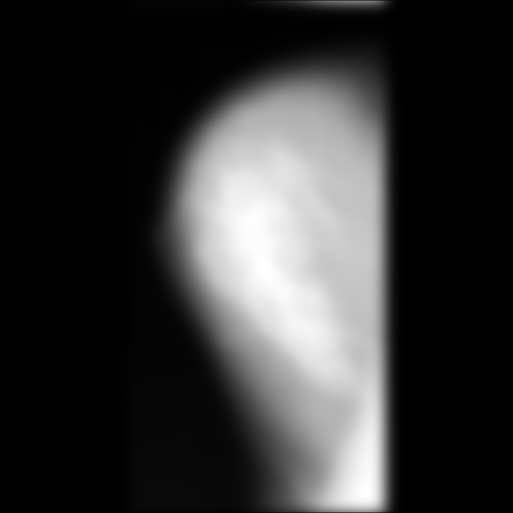

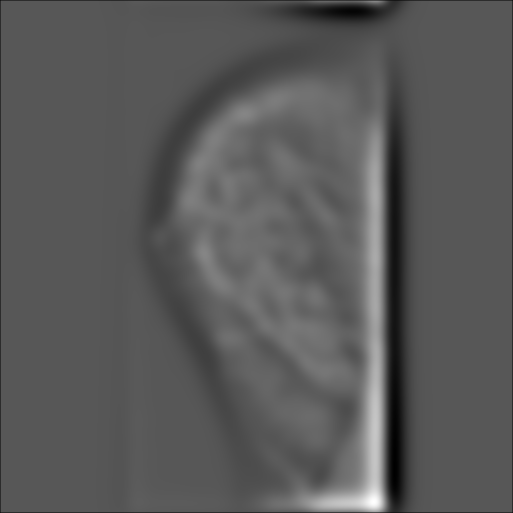

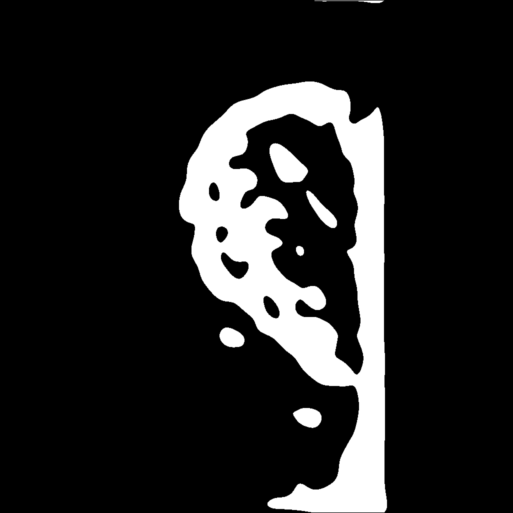

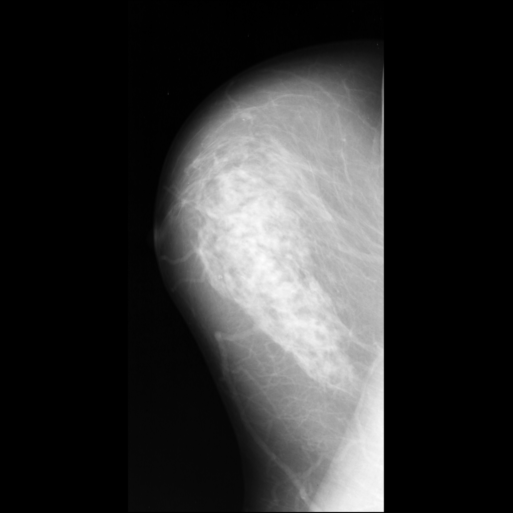

In [9]:
using Images, Colors, FixedPointNumbers, ImageView

imgMatrix = getImgMatrix("images/mamografias/mdb6.png")

filtered16 = gaussianFilter(imgMatrix, 16)
filtered8 = gaussianFilter(imgMatrix, 8)

diff = filtered16 - filtered8

out16 = filtered16 - minimum(filtered16)
out16 = (out16 / maximum(out16)) * 255
out16 = convert(Array{Int32},round(out16))
displayGrayMatrix(out16)

out = diff - minimum(diff)
out = (out / maximum(out)) * 255
out = convert(Array{Int32},round(out))

displayGrayMatrix(out)

out = otsuFilter(out)
displayGrayMatrix(out)

displayGrayMatrix(rotate(imgMatrix,-180))